In [ ]:
import os
import numpy as np
import gzip
from collections import defaultdict
import matplotlib.pyplot as plt

# --- Helper Functions (from original script) ---

def readGz(path):
  """Reads a gzip file line by line, evaluating each line as Python code."""
  for l in gzip.open(path, 'rt'):
    yield eval(l)

def readCSV(path):
  """Reads a gzip CSV file, skipping the header."""
  f = gzip.open(path, 'rt')
  f.readline()
  for l in f:
    yield l.strip().split(',')

# --- Main Exploration Function ---

def exploreData():
    """
    Reads the ratings data, calculates user/item statistics, and plots the distributions.
    """
    prefix = "../datasets/assignment1/" # Ensure this path is correct
    filepath = f"{prefix}train_Interactions.csv.gz"
    
    if not os.path.exists(filepath):
        print(f"Error: Data file not found at {filepath}")
        print("Please check the 'prefix' variable in the script.")
        return

    print("Reading data and calculating statistics...")
    
    # Store interaction data for calculation
    user_counts = defaultdict(int)
    item_counts = defaultdict(int)
    
    user_ratings_sum = defaultdict(float)
    item_ratings_sum = defaultdict(float)
    
    num_ratings = 0
    
    # Process all ratings
    for user, book, r in readCSV(filepath):
        r_float = float(r)
        
        # Counts
        user_counts[user] += 1
        item_counts[book] += 1
        
        # Sums for average calculation
        user_ratings_sum[user] += r_float
        item_ratings_sum[book] += r_float
        
        num_ratings += 1
        
    print(f"Total ratings processed: {num_ratings}")
    print(f"Total unique users: {len(user_counts)}")
    print(f"Total unique items: {len(item_counts)}")

    # Calculate final averages and extract count values
    
    # User Statistics
    user_interaction_counts = list(user_counts.values())
    user_avg_ratings = [user_ratings_sum[u] / user_counts[u] for u in user_counts]
    
    # Item Statistics
    item_interaction_counts = list(item_counts.values())
    item_avg_ratings = [item_ratings_sum[i] / item_counts[i] for i in item_counts]

    # --- Visualization ---
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # 1. User Interaction Counts
    ax = axes[0, 0]
    ax.hist(user_interaction_counts, bins=50, color='#3498db', edgecolor='black')
    ax.set_title('Distribution of User Interaction Counts (Activity)', fontsize=14)
    ax.set_xlabel('Number of Ratings Given by User')
    ax.set_ylabel('Number of Users (Log Scale)')
    ax.set_yscale('log')
    ax.grid(axis='y', alpha=0.5)

    # 2. Item Interaction Counts
    ax = axes[0, 1]
    ax.hist(item_interaction_counts, bins=50, color='#2ecc71', edgecolor='black')
    ax.set_title('Distribution of Item Interaction Counts (Popularity)', fontsize=14)
    ax.set_xlabel('Number of Ratings Received by Item')
    ax.set_ylabel('Number of Items (Log Scale)')
    ax.set_yscale('log')
    ax.grid(axis='y', alpha=0.5)

    # 3. User Average Ratings
    ax = axes[1, 0]
    ax.hist(user_avg_ratings, bins=25, color='#e74c3c', edgecolor='black')
    ax.set_title('Distribution of User Average Ratings', fontsize=14)
    ax.set_xlabel('Average Rating (0.0 - 5.0)')
    ax.set_ylabel('Number of Users')
    ax.grid(axis='y', alpha=0.5)

    # 4. Item Average Ratings
    ax = axes[1, 1]
    ax.hist(item_avg_ratings, bins=25, color='#f1c40f', edgecolor='black')
    ax.set_title('Distribution of Item Average Ratings', fontsize=14)
    ax.set_xlabel('Average Rating (0.0 - 5.0)')
    ax.set_ylabel('Number of Items')
    ax.grid(axis='y', alpha=0.5)

    fig.suptitle('Ratings Data Exploration', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # --- Print Summary Statistics ---
    print("\n--- Summary Statistics ---")
    
    def print_summary(data, name):
        data = np.array(data)
        if len(data) == 0:
            print(f"{name} data is empty.")
            return

        print(f"\n{name} Statistics:")
        print(f"  Mean: {np.mean(data):.4f}")
        print(f"  Median: {np.median(data):.4f}")
        print(f"  Min: {np.min(data):.0f}" if 'Count' in name else f"  Min: {np.min(data):.4f}")
        print(f"  Max: {np.max(data):.0f}" if 'Count' in name else f"  Max: {np.max(data):.4f}")
        
    print_summary(user_interaction_counts, "User Interaction Counts")
    print_summary(item_interaction_counts, "Item Interaction Counts")
    print_summary(user_avg_ratings, "User Average Ratings")
    print_summary(item_avg_ratings, "Item Average Ratings")

def analyze_cold_start():
    # --- Configuration ---
    prefix = "../datasets/assignment1/" # Ensure this path is correct
    train_file = f"{prefix}train_Interactions.csv.gz"
    pairs_file = f"{prefix}pairs_Rating.csv"

    # 1. Read Training Data to build the reference set
    print(f"1. Reading training data from {train_file}...")
    
    all_users_str = set()
    all_items_str = set()
    total_train_ratings = 0

    try:
        for user, book, rating in readCSV(train_file):
            all_users_str.add(user)
            all_items_str.add(book)
            total_train_ratings += 1
    except FileNotFoundError:
        print(f"Error: Training file not found at {train_file}")
        return

    print(f"   -> Training set size: {total_train_ratings} ratings.")
    print(f"   -> Unique Training Users: {len(all_users_str)}")
    print(f"   -> Unique Training Items: {len(all_items_str)}")
    
    print("-" * 50)

    # 2. Read Prediction File to build the test set
    print(f"2. Reading prediction pairs from {pairs_file}...")
    
    pairs_users = set()
    pairs_items = set()
    total_predictions = 0
    
    try:
        for l in open(pairs_file):
            if l.startswith("userID"):
                continue
            u_str, b_str = l.strip().split(',')
            pairs_users.add(u_str)
            pairs_items.add(b_str)
            total_predictions += 1
    except FileNotFoundError:
        print(f"Error: Pairs file not found at {pairs_file}")
        return

    print(f"   -> Total prediction pairs: {total_predictions}")
    print(f"   -> Unique users in pairs: {len(pairs_users)}")
    print(f"   -> Unique items in pairs: {len(pairs_items)}")

    # 3. Calculate Cold-Start Metrics
    
    # Users/Items present in the pairs file but NOT in the training file
    new_users = pairs_users - all_users_str
    new_items = pairs_items - all_items_str

    total_pairs_users = len(pairs_users)
    total_pairs_items = len(pairs_items)

    pct_new_users = (len(new_users) / total_pairs_users) * 100 if total_pairs_users > 0 else 0
    pct_new_items = (len(new_items) / total_pairs_items) * 100 if total_pairs_items > 0 else 0
    
    print("-" * 50)
    print("❄️ Cold-Start Analysis: Unseen Entities in Prediction File ❄️")
    print("-" * 50)
    
    # Total percentage of predictions relying on fallback (worst-case scenario)
    total_unseen_pairs = 0
    
    # We must iterate the pairs file one last time to count how many PAIRS are cold-start
    # (i.e., where EITHER the user OR the item is new)
    for l in open(pairs_file):
        if l.startswith("userID"):
            continue
        u_str, b_str = l.strip().split(',')
        if u_str not in all_users_str or b_str not in all_items_str:
             total_unseen_pairs += 1

    pct_unseen_pairs = (total_unseen_pairs / total_predictions) * 100 if total_predictions > 0 else 0

    print(f"Unseen Users (New Users):   {len(new_users)} ({pct_new_users:.2f}%)")
    print(f"Unseen Items (New Items):   {len(new_items)} ({pct_new_items:.2f}%)")
    print("-" * 50)
    print(f"Total Predictions Relying on Fallback: {total_unseen_pairs} pairs ({pct_unseen_pairs:.2f}%)")
    print("This percentage is the minimum amount of error dilution you will face.")
    print("-" * 50)

def analyze_cold_start():
    # --- Configuration ---
    prefix = "../datasets/assignment1/" # Ensure this path is correct
    train_file = f"{prefix}train_Interactions.csv.gz"
    pairs_file = f"{prefix}pairs_Rating.csv"

    # 1. Read Training Data to build the reference set
    print(f"1. Reading training data from {train_file}...")
    
    all_users_str = set()
    all_items_str = set()
    total_train_ratings = 0

    try:
        for user, book, rating in readCSV(train_file):
            all_users_str.add(user)
            all_items_str.add(book)
            total_train_ratings += 1
    except FileNotFoundError:
        print(f"Error: Training file not found at {train_file}")
        return

    print(f"   -> Training set size: {total_train_ratings} ratings.")
    print(f"   -> Unique Training Users: {len(all_users_str)}")
    print(f"   -> Unique Training Items: {len(all_items_str)}")
    
    print("-" * 50)

    # 2. Read Prediction File to build the test set
    print(f"2. Reading prediction pairs from {pairs_file}...")
    
    pairs_users = set()
    pairs_items = set()
    total_predictions = 0
    
    try:
        for l in open(pairs_file):
            if l.startswith("userID"):
                continue
            u_str, b_str = l.strip().split(',')
            pairs_users.add(u_str)
            pairs_items.add(b_str)
            total_predictions += 1
    except FileNotFoundError:
        print(f"Error: Pairs file not found at {pairs_file}")
        return

    print(f"   -> Total prediction pairs: {total_predictions}")
    print(f"   -> Unique users in pairs: {len(pairs_users)}")
    print(f"   -> Unique items in pairs: {len(pairs_items)}")

    # 3. Calculate Cold-Start Metrics
    
    # Users/Items present in the pairs file but NOT in the training file
    new_users = pairs_users - all_users_str
    new_items = pairs_items - all_items_str

    total_pairs_users = len(pairs_users)
    total_pairs_items = len(pairs_items)

    pct_new_users = (len(new_users) / total_pairs_users) * 100 if total_pairs_users > 0 else 0
    pct_new_items = (len(new_items) / total_pairs_items) * 100 if total_pairs_items > 0 else 0
    
    print("-" * 50)
    print("❄️ Cold-Start Analysis: Unseen Entities in Prediction File ❄️")
    print("-" * 50)
    
    # Total percentage of predictions relying on fallback (worst-case scenario)
    total_unseen_pairs = 0
    
    # We must iterate the pairs file one last time to count how many PAIRS are cold-start
    # (i.e., where EITHER the user OR the item is new)
    for l in open(pairs_file):
        if l.startswith("userID"):
            continue
        u_str, b_str = l.strip().split(',')
        if u_str not in all_users_str or b_str not in all_items_str:
             total_unseen_pairs += 1

    pct_unseen_pairs = (total_unseen_pairs / total_predictions) * 100 if total_predictions > 0 else 0

    print(f"Unseen Users (New Users):   {len(new_users)} ({pct_new_users:.2f}%)")
    print(f"Unseen Items (New Items):   {len(new_items)} ({pct_new_items:.2f}%)")
    print("-" * 50)
    print(f"Total Predictions Relying on Fallback: {total_unseen_pairs} pairs ({pct_unseen_pairs:.2f}%)")
    print("This percentage is the minimum amount of error dilution you will face.")
    print("-" * 50)

Reading data and calculating statistics...
Total ratings processed: 200000
Total unique users: 27945
Total unique items: 6688


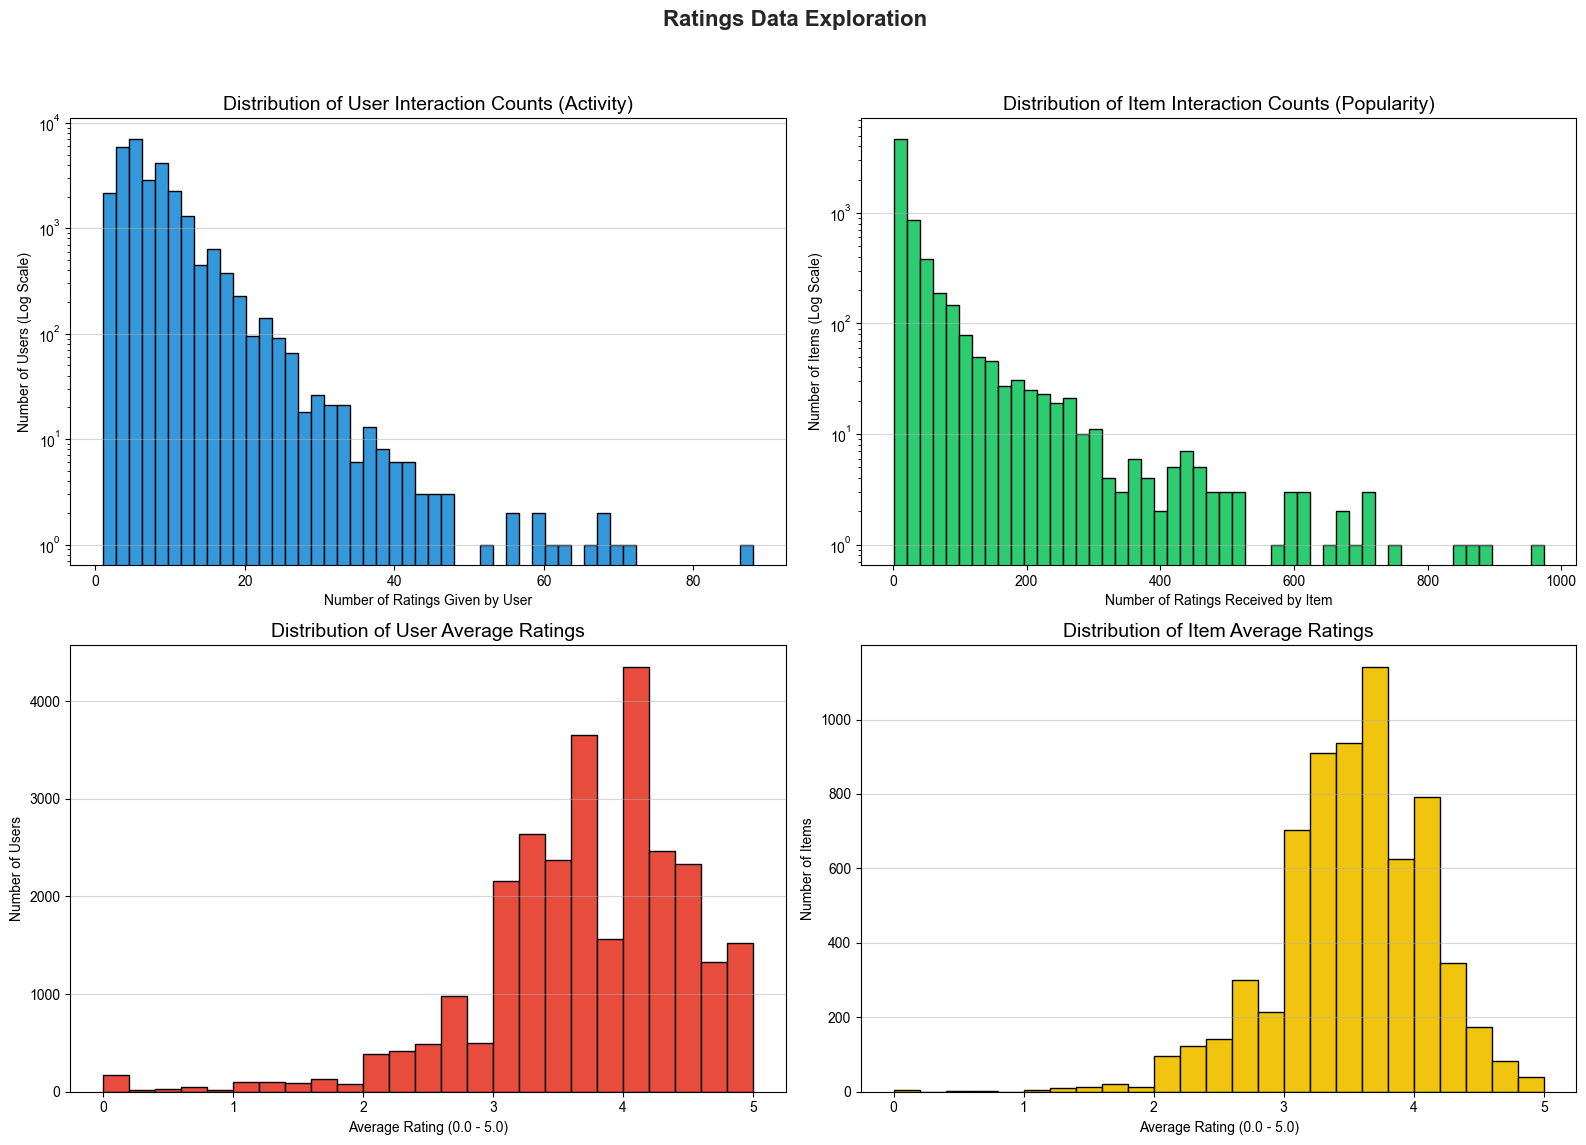


--- Summary Statistics ---

User Interaction Counts Statistics:
  Mean: 7.1569
  Median: 6.0000
  Min: 1
  Max: 88

Item Interaction Counts Statistics:
  Mean: 29.9043
  Median: 11.0000
  Min: 1
  Max: 974

User Average Ratings Statistics:
  Mean: 3.7035
  Median: 3.8000
  Min: 0.0000
  Max: 5.0000

Item Average Ratings Statistics:
  Mean: 3.5134
  Median: 3.5676
  Min: 0.0000
  Max: 5.0000


In [16]:
exploreData()

In [17]:
import os
import numpy as np
import gzip
from collections import defaultdict

# PyTorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F 

import matplotlib.pyplot as plt


# ==============================================================
#                     Helper Functions
# ==============================================================

def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        yield l.strip().split(',')

def getGlobalAverage(trainRatings):
    return np.mean(trainRatings)


# ==============================================================
#                     Dataset Class
# ==============================================================

class RatingsDataset(Dataset):
    """Custom PyTorch Dataset for ratings."""
    def __init__(self, ratings):
        self.users = torch.LongTensor([r[0] for r in ratings])
        self.items = torch.LongTensor([r[1] for r in ratings])
        self.ratings = torch.FloatTensor([r[2] for r in ratings])

    def __getitem__(self, index):
        return self.users[index], self.items[index], self.ratings[index]

    def __len__(self):
        return len(self.ratings)


# ==============================================================
#                         MF MODEL
# ==============================================================

class MFModel(nn.Module):
    """
    Matrix Factorization:
    r_ui = α + β_u + β_i + <γ_u, γ_i>
    """
    def __init__(self, n_users, n_items, latent_dim=10):
        super().__init__()
        
        # Bias terms
        self.user_bias = nn.Embedding(n_users, 1)
        self.item_bias = nn.Embedding(n_items, 1)
        self.global_bias = nn.Parameter(torch.zeros(1))  # start centered

        # Latent factors
        self.user_gamma = nn.Embedding(n_users, latent_dim)
        self.item_gamma = nn.Embedding(n_items, latent_dim)

        self._init_weights()

    def _init_weights(self):
        nn.init.normal_(self.user_gamma.weight, mean=0.0, std=0.05)
        nn.init.normal_(self.item_gamma.weight, mean=0.0, std=0.05)
        
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

    def forward(self, user_ids, item_ids):
        u_bias = self.user_bias(user_ids)
        i_bias = self.item_bias(item_ids)
        u_gamma = self.user_gamma(user_ids)
        i_gamma = self.item_gamma(item_ids)

        interaction = (u_gamma * i_gamma).sum(dim=1, keepdim=True)
        raw = self.global_bias + u_bias + i_bias + interaction

        return raw.squeeze()


# ==============================================================
#                      MAIN TRAIN FUNCTION
# ==============================================================

def predictRating():

    # Hyperparameters
    BATCH_SIZE = 256
    LATENT_DIM = 1
    LR = 1e-3
    LAMBDA = 10
    N_EPOCHS = 50
    CSV_TRIGGER = 1.4646   # write predictions if val MSE passes this threshold
    
    device = torch.device("mps")
    print("Using device:", device)

    prefix = "../datasets/assignment1/"
    
    # ---------------------------------------------------------------
    # Load Data
    # ---------------------------------------------------------------

    print("Loading data...")
    allRatings = []
    userRatings = defaultdict(list)
    users_set, items_set = set(), set()
    
    for user, book, r in readCSV(prefix + "train_Interactions.csv.gz"):
        r = float(r)
        allRatings.append((user, book, r))
        userRatings[user].append(r)
        users_set.add(user)
        items_set.add(book)


    # ID Mapping
    user_to_int = {u: i for i, u in enumerate(users_set)}
    item_to_int = {b: i for i, b in enumerate(items_set)}
    n_users, n_items = len(user_to_int), len(item_to_int)

    ratings_int = [(user_to_int[u], item_to_int[b], r)
                   for u, b, r in allRatings]

    np.random.shuffle(ratings_int)
    N = len(ratings_int)

    train_set = ratings_int[:int(0.8*N)]
    val_set   = ratings_int[int(0.8*N):int(0.9*N)]
    test_set  = ratings_int[int(0.9*N):]

    train_loader = DataLoader(RatingsDataset(train_set), batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(RatingsDataset(val_set), batch_size=BATCH_SIZE)
    test_loader  = DataLoader(RatingsDataset(test_set), batch_size=BATCH_SIZE)

    # Fallback averages
    globalAverage = getGlobalAverage([r for _,_,r in train_set])
    userAverage = {u: np.mean(userRatings[u_str]) for u_str,u in user_to_int.items() if u_str in userRatings}

    # ---------------------------------------------------------------
    # Model & Optimizer
    # ---------------------------------------------------------------
    model = MFModel(n_users, n_items, LATENT_DIM).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, N_EPOCHS)
    criterion = nn.MSELoss(reduction='sum')

    best_val = float("inf")
    alpha_values = []

    # ---------------------------------------------------------------
    # Training Loop
    # ---------------------------------------------------------------

    print("Training...")

    for epoch in range(N_EPOCHS):
        model.train()
        total_train_loss = 0

        for u, i, r in train_loader:
            u, i, r = u.to(device), i.to(device), r.to(device)
            
            optimizer.zero_grad()
            predictions = model(u, i)

            base_loss = criterion(predictions, r)

            reg = (
                model.user_bias(u).pow(2).sum()
                + model.item_bias(i).pow(2).sum()
                + model.user_gamma(u).pow(2).sum()
                + model.item_gamma(i).pow(2).sum()
            )

            loss = base_loss + LAMBDA * reg
            loss.backward()
            optimizer.step()

            total_train_loss += base_loss.item()

        train_mse = total_train_loss / len(train_set)

        # ------------------ Validation ------------------
        model.eval()
        total_val = 0
        with torch.no_grad():
            for u, i, r in val_loader:
                u, i, r = u.to(device), i.to(device), r.to(device)
                pred = model(u, i)
                total_val += F.mse_loss(pred, r, reduction='sum').item()

        val_mse = total_val / len(val_set)

        alpha_values.append(model.global_bias.item())

        print(f"Epoch {epoch+1}/{N_EPOCHS} | Train MSE={train_mse:.4f} | Val MSE={val_mse:.4f}")

        # ------------------ Save Best Model ------------------
        if val_mse < best_val:
            best_val = val_mse
            torch.save(model.state_dict(), "best_mf_model.pth")
            print(f"    > New BEST model saved (Val MSE = {val_mse:.4f})")

            # -------------------------------------------------
            #   WRITE CSV IF NEW BEST < TRIGGER
            # -------------------------------------------------
            if val_mse < CSV_TRIGGER:
                print(f"    > Val MSE < {CSV_TRIGGER}! Writing CSV predictions...")
                write_predictions(model, prefix, user_to_int, item_to_int, userAverage, globalAverage, device)

        scheduler.step()


    print("\nTraining complete.")
    print("Best Validation MSE =", best_val)

def write_predictions(model, prefix, user_to_int, item_to_int, userAverage, globalAverage, device):
    """
    Writes predictions_Rating_MF.csv using current best model state.
    """
    model.eval()

    out_path = "predictions_Rating_MF.csv"
    if os.path.exists(out_path):
        os.remove(out_path)

    f_out = open(out_path, "w")

    for line in open(prefix + "pairs_Rating.csv"):
        if line.startswith("userID"):
            f_out.write(line)
            continue

        u_str, b_str = line.strip().split(',')

        if (u_str in user_to_int) and (b_str in item_to_int):
            u_idx = torch.LongTensor([user_to_int[u_str]]).to(device)
            b_idx = torch.LongTensor([item_to_int[b_str]]).to(device)

            with torch.no_grad():
                pred = model(u_idx, b_idx).item()

            pred = max(0.0, min(5.0, pred))  # clamp to rating scale
            f_out.write(f"{u_str},{b_str},{pred}\n")
        else:
            # fallback
            if u_str in userAverage:
                fallback = userAverage[u_str]
            else:
                fallback = globalAverage

            fallback = max(0.0, min(5.0, fallback))
            f_out.write(f"{u_str},{b_str},{fallback}\n")

    f_out.close()
    print("    > CSV written:", out_path)



# ==============================================================
#                         RUN
# ==============================================================

if __name__ == "__main__":
    predictRating()

Using device: mps
Loading data...
Training...
Epoch 1/50 | Train MSE=12.5401 | Val MSE=10.1522
    > New BEST model saved (Val MSE = 10.1522)
Epoch 2/50 | Train MSE=8.3843 | Val MSE=6.9445
    > New BEST model saved (Val MSE = 6.9445)
Epoch 3/50 | Train MSE=5.8053 | Val MSE=4.8942
    > New BEST model saved (Val MSE = 4.8942)


KeyboardInterrupt: 

In [34]:
import os
import numpy as np
import gzip
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


# ==============================================================
#                     Helper Functions
# ==============================================================

def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        yield l.strip().split(',')


# ==============================================================
#                     Dataset with Features
# ==============================================================

class FeatureRatingsDataset(Dataset):
    def __init__(self, ratings, user_features, item_features):
        self.users = torch.LongTensor([r[0] for r in ratings])
        self.items = torch.LongTensor([r[1] for r in ratings])
        self.ratings = torch.FloatTensor([r[2] for r in ratings])
        self.user_features = user_features  # dict: user_id -> feature tensor
        self.item_features = item_features  # dict: item_id -> feature tensor

    def __getitem__(self, index):
        u = self.users[index].item()
        i = self.items[index].item()
        return (self.users[index], self.items[index], 
                self.user_features[u], self.item_features[i],
                self.ratings[index])

    def __len__(self):
        return len(self.ratings)


# ==============================================================
#              FACTORIZATION MACHINE MODEL
# ==============================================================

class FactorizationMachineModel(nn.Module):
    """
    Factorization Machine that models interactions between:
    - User ID and Item ID (classic MF)
    - User features (activity, variance, avg rating, etc.)
    - Item features (popularity, variance, avg rating, etc.)
    - Cross-features between user and item characteristics
    """
    def __init__(self, n_users, n_items, latent_dim=20, 
                 user_feat_dim=5, item_feat_dim=5):
        super().__init__()
        
        # Global bias
        self.global_bias = nn.Parameter(torch.zeros(1))
        
        # First-order weights (linear effects)
        self.user_bias = nn.Embedding(n_users, 1)
        self.item_bias = nn.Embedding(n_items, 1)
        
        # Weights for features
        self.user_feat_weights = nn.Linear(user_feat_dim, 1, bias=False)
        self.item_feat_weights = nn.Linear(item_feat_dim, 1, bias=False)
        
        # Second-order (latent factors for interactions)
        # User-Item interaction
        self.user_factors = nn.Embedding(n_users, latent_dim)
        self.item_factors = nn.Embedding(n_items, latent_dim)
        
        # User-ItemFeatures interaction
        self.user_feat_factors = nn.Embedding(n_users, latent_dim // 2)
        self.item_feat_factors = nn.Linear(item_feat_dim, latent_dim // 2, bias=False)
        
        # UserFeatures-Item interaction
        self.user_feat_factors_2 = nn.Linear(user_feat_dim, latent_dim // 2, bias=False)
        self.item_feat_factors_2 = nn.Embedding(n_items, latent_dim // 2)
        
        # UserFeatures-ItemFeatures interaction (fully feature-based)
        self.user_feat_embed = nn.Linear(user_feat_dim, latent_dim // 4, bias=False)
        self.item_feat_embed = nn.Linear(item_feat_dim, latent_dim // 4, bias=False)
        
        self._init_weights()
    
    def _init_weights(self):
        nn.init.zeros_(self.global_bias)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)
        
        # Small random initialization for factors
        nn.init.normal_(self.user_factors.weight, 0, 0.01)
        nn.init.normal_(self.item_factors.weight, 0, 0.01)
        nn.init.normal_(self.user_feat_factors.weight, 0, 0.01)
        nn.init.normal_(self.item_feat_factors_2.weight, 0, 0.01)
        
        # Xavier for linear layers
        for layer in [self.user_feat_weights, self.item_feat_weights,
                      self.item_feat_factors, self.user_feat_factors_2,
                      self.user_feat_embed, self.item_feat_embed]:
            nn.init.xavier_normal_(layer.weight)
    
    def forward(self, user_ids, item_ids, user_feats, item_feats):
        # First-order effects (linear)
        pred = self.global_bias
        pred = pred + self.user_bias(user_ids).squeeze(-1)
        pred = pred + self.item_bias(item_ids).squeeze(-1)
        pred = pred + self.user_feat_weights(user_feats).squeeze(-1)
        pred = pred + self.item_feat_weights(item_feats).squeeze(-1)
        
        # Second-order interaction: User x Item (classic MF)
        u_factors = self.user_factors(user_ids)
        i_factors = self.item_factors(item_ids)
        pred = pred + (u_factors * i_factors).sum(dim=1)
        
        # Second-order: User x ItemFeatures
        u_feat_f = self.user_feat_factors(user_ids)
        i_feat_f = self.item_feat_factors(item_feats)
        pred = pred + (u_feat_f * i_feat_f).sum(dim=1)
        
        # Second-order: UserFeatures x Item
        u_feat_f2 = self.user_feat_factors_2(user_feats)
        i_feat_f2 = self.item_feat_factors_2(item_ids)
        pred = pred + (u_feat_f2 * i_feat_f2).sum(dim=1)
        
        # Second-order: UserFeatures x ItemFeatures
        u_feat_emb = self.user_feat_embed(user_feats)
        i_feat_emb = self.item_feat_embed(item_feats)
        pred = pred + (u_feat_emb * i_feat_emb).sum(dim=1)
        
        return pred


# ==============================================================
#               Feature Engineering
# ==============================================================

def compute_features(allRatings, user_to_int, item_to_int):
    """Compute statistical features for users and items"""
    
    n_users = len(user_to_int)
    n_items = len(item_to_int)
    
    # Collect ratings per user/item
    user_ratings = defaultdict(list)
    item_ratings = defaultdict(list)
    
    for u_str, i_str, r in allRatings:
        u_idx = user_to_int[u_str]
        i_idx = item_to_int[i_str]
        user_ratings[u_idx].append(r)
        item_ratings[i_idx].append(r)
    
    # User features: [count_log, mean, std, min, max]
    user_features = {}
    for u_idx in range(n_users):
        ratings = user_ratings[u_idx] if u_idx in user_ratings else [0.0]
        user_features[u_idx] = torch.FloatTensor([
            np.log1p(len(ratings)),           # log activity
            np.mean(ratings),                  # average rating
            np.std(ratings) if len(ratings) > 1 else 0.0,  # rating variance
            np.min(ratings),                   # min rating
            np.max(ratings)                    # max rating
        ])
    
    # Item features: [count_log, mean, std, min, max]
    item_features = {}
    for i_idx in range(n_items):
        ratings = item_ratings[i_idx] if i_idx in item_ratings else [0.0]
        item_features[i_idx] = torch.FloatTensor([
            np.log1p(len(ratings)),           # log popularity
            np.mean(ratings),                  # average rating
            np.std(ratings) if len(ratings) > 1 else 0.0,  # rating variance
            np.min(ratings),                   # min rating
            np.max(ratings)                    # max rating
        ])
    
    # Normalize features
    user_feat_matrix = torch.stack([user_features[i] for i in range(n_users)])
    item_feat_matrix = torch.stack([item_features[i] for i in range(n_items)])
    
    # Standardize (mean=0, std=1)
    user_mean = user_feat_matrix.mean(dim=0)
    user_std = user_feat_matrix.std(dim=0) + 1e-8
    item_mean = item_feat_matrix.mean(dim=0)
    item_std = item_feat_matrix.std(dim=0) + 1e-8
    
    for u_idx in range(n_users):
        user_features[u_idx] = (user_features[u_idx] - user_mean) / user_std
    
    for i_idx in range(n_items):
        item_features[i_idx] = (item_features[i_idx] - item_mean) / item_std
    
    return user_features, item_features


# ==============================================================
#               CSV Writing
# ==============================================================

def write_predictions(model, prefix, user_to_int, item_to_int, 
                      user_features, item_features,
                      user_avg, item_avg, globalAverage, device):
    """Write predictions"""
    model.eval()
    
    out_path = "predictions_Rating.csv"
    if os.path.exists(out_path):
        os.remove(out_path)
    
    f_out = open(out_path, "w")
    
    for line in open(prefix + "pairs_Rating.csv"):
        if line.startswith("userID"):
            f_out.write(line)
            continue
        
        u_str, b_str = line.strip().split(',')
        
        is_user = u_str in user_to_int
        is_item = b_str in item_to_int
        
        if is_user and is_item:
            u_idx = user_to_int[u_str]
            b_idx = item_to_int[b_str]
            
            u_tensor = torch.LongTensor([u_idx]).to(device)
            b_tensor = torch.LongTensor([b_idx]).to(device)
            u_feat = user_features[u_idx].unsqueeze(0).to(device)
            i_feat = item_features[b_idx].unsqueeze(0).to(device)
            
            with torch.no_grad():
                pred = model(u_tensor, b_tensor, u_feat, i_feat).item()
        
        elif is_user:
            pred = user_avg.get(u_str, globalAverage)
        elif is_item:
            pred = item_avg.get(b_str, globalAverage)
        else:
            pred = globalAverage
        
        pred = max(0.0, min(5.0, pred))
        f_out.write(f"{u_str},{b_str},{pred}\n")
    
    f_out.close()
    print(f"    > CSV written: {out_path}")


# ==============================================================
#                      MAIN TRAIN FUNCTION
# ==============================================================

def predictRating():
    
    # Optimized hyperparameters
    BATCH_SIZE = 512
    LATENT_DIM = 4
    LR = 9e-4
    WEIGHT_DECAY = 1e-5
    LAMBDA = 3.0
    N_EPOCHS = 20
    PATIENCE = 20
    
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print("Using device:", device)
    
    prefix = "../datasets/assignment1/"
    
    # ---------------------------------------------------------------
    # Load Data
    # ---------------------------------------------------------------
    print("Loading data...")
    allRatings = []
    users_set, items_set = set(), set()
    user_ratings = defaultdict(list)
    item_ratings = defaultdict(list)
    
    for user, book, r in readCSV(prefix + "train_Interactions.csv.gz"):
        r = float(r)
        allRatings.append((user, book, r))
        users_set.add(user)
        items_set.add(book)
        user_ratings[user].append(r)
        item_ratings[book].append(r)
    
    # Compute statistics
    user_avg = {u: np.mean(user_ratings[u]) for u in user_ratings}
    item_avg = {i: np.mean(item_ratings[i]) for i in item_ratings}
    
    # ID Mapping
    user_to_int = {u: i for i, u in enumerate(sorted(users_set))}
    item_to_int = {b: i for i, b in enumerate(sorted(items_set))}
    n_users, n_items = len(user_to_int), len(item_to_int)
    
    print(f"Users: {n_users}, Items: {n_items}, Ratings: {len(allRatings)}")
    
    # ---------------------------------------------------------------
    # Feature Engineering
    # ---------------------------------------------------------------
    print("Computing features...")
    user_features, item_features = compute_features(
        allRatings, user_to_int, item_to_int
    )
    
    # Convert to integer-coded data
    ratings_int = [(user_to_int[u], item_to_int[b], r)
                   for u, b, r in allRatings]
    
    globalAverage = float(np.mean([r for _, _, r in ratings_int]))
    print(f"Global average: {globalAverage:.4f}")
    
    # ---------------------------------------------------------------
    # Train/Val Split
    # ---------------------------------------------------------------
    np.random.seed(42)
    np.random.shuffle(ratings_int)
    N = len(ratings_int)
    
    split_point = int(0.8 * N)
    train_set = ratings_int[:split_point]
    val_set = ratings_int[split_point:]
    
    train_loader = DataLoader(
        FeatureRatingsDataset(train_set, user_features, item_features),
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0
    )
    val_loader = DataLoader(
        FeatureRatingsDataset(val_set, user_features, item_features),
        batch_size=BATCH_SIZE * 2,
        num_workers=0
    )
    
    print(f"Train: {len(train_set)}, Val: {len(val_set)}")
    
    # ---------------------------------------------------------------
    # Model Training
    # ---------------------------------------------------------------
    print("\nTraining Factorization Machine Model...")
    
    model = FactorizationMachineModel(
        n_users, n_items,
        latent_dim=LATENT_DIM,
        user_feat_dim=5,
        item_feat_dim=5
    ).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5,
    )
    
    best_val = float("inf")
    patience_counter = 0
    
    for epoch in range(N_EPOCHS):
        # Training
        model.train()
        total_train_mse = 0.0
        
        for u, i, u_feat, i_feat, r in train_loader:
            u = u.to(device)
            i = i.to(device)
            u_feat = u_feat.to(device)
            i_feat = i_feat.to(device)
            r = r.to(device)
            
            optimizer.zero_grad()
            pred = model(u, i, u_feat, i_feat)
            
            # MSE loss
            mse_loss = F.mse_loss(pred, r)
            
            # Light L2 regularization
            reg_loss = sum(p.pow(2).sum() for p in model.parameters())
            
            loss = mse_loss + LAMBDA * reg_loss / len(train_set)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_train_mse += mse_loss.item() * len(u)
        
        train_mse = total_train_mse / len(train_set)
        
        # Validation
        model.eval()
        total_val_mse = 0.0
        with torch.no_grad():
            for u, i, u_feat, i_feat, r in val_loader:
                u = u.to(device)
                i = i.to(device)
                u_feat = u_feat.to(device)
                i_feat = i_feat.to(device)
                r = r.to(device)
                
                pred = model(u, i, u_feat, i_feat)
                total_val_mse += F.mse_loss(pred, r, reduction='sum').item()
        
        val_mse = total_val_mse / len(val_set)
        
        scheduler.step(val_mse)
        
        print(f"Epoch {epoch+1:3d}/{N_EPOCHS} | "
                  f"Train: {train_mse:.4f} | "
                  f"Val: {val_mse:.4f}")
        
        # Track best
        if val_mse < best_val and train_mse < 1.46:
            improvement = best_val - val_mse
            best_val = val_mse
            patience_counter = 0
            torch.save(model.state_dict(), "best_fm_model.pth")
            print(f"    >>> NEW BEST: {val_mse:.4f} (improved by {improvement:.4f})")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"    > Early stopping at epoch {epoch + 1}")
                break
    
    # ---------------------------------------------------------------
    # Generate Predictions
    # ---------------------------------------------------------------
    print(f"\n{'='*60}")
    print(f"Best Validation MSE: {best_val:.4f}")
    print(f"{'='*60}")
    
    model.load_state_dict(torch.load("best_fm_model.pth"))
    
    print("\nWriting predictions...")
    write_predictions(
        model=model,
        prefix=prefix,
        user_to_int=user_to_int,
        item_to_int=item_to_int,
        user_features=user_features,
        item_features=item_features,
        user_avg=user_avg,
        item_avg=item_avg,
        globalAverage=globalAverage,
        device=device
    )
    
    print(f"\nTraining complete!")


if __name__ == "__main__":
    predictRating()

Using device: mps
Loading data...
Users: 27945, Items: 6688, Ratings: 200000
Computing features...
Global average: 3.6870
Train: 160000, Val: 40000

Training Factorization Machine Model...
Epoch   1/20 | Train: 13.5596 | Val: 8.3658
Epoch   2/20 | Train: 5.3937 | Val: 3.6888
Epoch   3/20 | Train: 2.7011 | Val: 2.6360
Epoch   4/20 | Train: 1.9374 | Val: 2.2776
Epoch   5/20 | Train: 1.5205 | Val: 2.0740
Epoch   6/20 | Train: 1.2529 | Val: 1.9536
    >>> NEW BEST: 1.9536 (improved by inf)
Epoch   7/20 | Train: 1.0803 | Val: 1.8809
    >>> NEW BEST: 1.8809 (improved by 0.0726)
Epoch   8/20 | Train: 0.9700 | Val: 1.8408
    >>> NEW BEST: 1.8408 (improved by 0.0401)
Epoch   9/20 | Train: 0.8962 | Val: 1.8194
    >>> NEW BEST: 1.8194 (improved by 0.0213)
Epoch  10/20 | Train: 0.8429 | Val: 1.8069
    >>> NEW BEST: 1.8069 (improved by 0.0125)
Epoch  11/20 | Train: 0.8010 | Val: 1.8020
    >>> NEW BEST: 1.8020 (improved by 0.0050)
Epoch  12/20 | Train: 0.7666 | Val: 1.8021
Epoch  13/20 | Train:

In [50]:
from transformers import CLIPTokenizer, CLIPTextModel
import torch
import numpy as np

from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

prefix = "../datasets/assignment1/" # Ensure this path is correct

def clip_embed(texts, tokenizer, model, batch_size=64, device="mps"):
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]

        inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=77,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)

        emb = outputs.last_hidden_state.mean(dim=1)
        all_embeddings.append(emb.cpu().numpy())

    return np.vstack(all_embeddings)


data = [d for d in readGz(f"{prefix}train_Category.json.gz")]

# -------------------------
# Load CLIP text encoder
# -------------------------
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to("mps")
model.eval()

# Prepare text + labels
corpus = [d['review_text'] for d in data]
y_all = np.array([d['genreID'] for d in data])

# -------------------------
# Encode with CLIP
# -------------------------
print("Encoding training text with CLIP...")
X_all = clip_embed(corpus, tokenizer, model)

# Train/validation split
Xtrain, Xvalid, ytrain, yvalid = train_test_split(
X_all, y_all, test_size=0.1, random_state=42
)

# -------------------------
# Train classifier
# -------------------------
mod = LogisticRegression(
C=20,
penalty='l2',
solver='liblinear',
max_iter=2000,
verbose=1
)
mod.fit(Xtrain, ytrain)

# Validation accuracy
pred_valid = mod.predict(Xvalid)
acc = (pred_valid == yvalid).mean()
print("Validation accuracy:", acc)

# -------------------------
# Encode test data
# -------------------------
# data_test = list(readGz(f"{prefix}test_Category.json.gz"))
# corpus_test = [d['review_text'] for d in data_test]

# print("Encoding test text with CLIP...")
# Xtest = clip_embed(corpus_test, tokenizer, model)

# pred_test = mod.predict(Xtest)

# # Write output file
# if os.path.exists("predictions_Category.csv"):
#     os.remove("predictions_Category.csv")
# predictions = open("predictions_Category.csv", 'w')
# predictions.write("userID,reviewID,prediction\n")

# for ind, l in enumerate(readGz(f"{prefix}test_Category.json.gz")):
#     predictions.write(l['user_id'] + ',' +
#                       l['review_id'] + ',' +
#                       str(pred_test[ind]) + "\n")
# predictions.close()


Encoding training text with CLIP...


100%|██████████| 1563/1563 [04:52<00:00,  5.34it/s]


[LibLinear]iter  1 act 6.568e+05 pre 5.935e+05 delta 1.330e-01 f 1.248e+06 |g| 9.993e+06 CG   1
cg reaches trust region boundary
iter  2 act 1.015e+05 pre 8.796e+04 delta 1.626e-01 f 5.909e+05 |g| 2.044e+06 CG   3
cg reaches trust region boundary
iter  3 act 5.744e+04 pre 5.640e+04 delta 4.401e-01 f 4.894e+05 |g| 5.625e+05 CG   2
cg reaches trust region boundary
iter  4 act 9.291e+04 pre 9.172e+04 delta 6.448e-01 f 4.319e+05 |g| 3.449e+05 CG   2
iter  5 act 6.187e+04 pre 5.086e+04 delta 7.349e-01 f 3.390e+05 |g| 5.083e+05 CG   3
cg reaches trust region boundary
iter  6 act 2.594e+04 pre 2.186e+04 delta 9.150e-01 f 2.772e+05 |g| 1.948e+05 CG   5
cg reaches trust region boundary
iter  7 act 1.257e+04 pre 1.142e+04 delta 1.156e+00 f 2.512e+05 |g| 9.488e+04 CG   4
cg reaches trust region boundary
iter  8 act 7.747e+03 pre 7.512e+03 delta 1.339e+00 f 2.386e+05 |g| 5.268e+04 CG   6
cg reaches trust region boundary
iter  9 act 4.186e+03 pre 3.931e+03 delta 1.461e+00 f 2.309e+05 |g| 3.291e+04 

In [ ]:
import os
import math
import scipy.optimize
import numpy as np
import string
import random
import gzip
import torch

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
from tqdm import tqdm

from transformers import RobertaTokenizer, RobertaModel

prefix = "../datasets/assignment1/"  # Adjust if needed


# ---------------------------
# Helpers to read the dataset
# ---------------------------
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        u, b, r = l.strip().split(',')
        r = int(r)
        yield u, b, r


# ---------------------------
#  RoBERTa-Large Embedding
# ---------------------------
def roberta_embed(texts, tokenizer, model, batch_size=16, device="mps"):
    """Return a numpy array of pooled embeddings for a list of strings."""
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]

        enc = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=256,      # Good for review text
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model(**enc)

        hidden = outputs.last_hidden_state   # [batch, seq, 1024]

        # --- Mean Pooling ---
        mask = enc['attention_mask'].unsqueeze(-1).expand(hidden.size())
        hidden = hidden * mask
        summed = hidden.sum(dim=1)
        counts = mask.sum(dim=1)
        emb = summed / counts

        all_embeddings.append(emb.cpu().numpy())

    return np.vstack(all_embeddings)


# ---------------------------
#  Category Prediction (Updated!)
# ---------------------------
print("Loading training data...")
data = [d for d in readGz(f"{prefix}train_Category.json.gz")]

# -----------------------------
#   Load RoBERTa-large + MPS
# -----------------------------
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

print("Loading RoBERTa-large model...")
tokenizer = RobertaTokenizer.from_pretrained("roberta-large")
model = RobertaModel.from_pretrained("roberta-large").to(device)
model.eval()

# Prepare corpus + labels
corpus = [d["review_text"] for d in data]
y_all = np.array([d["genreID"] for d in data])

# -----------------------------
#   Encode all training text
# -----------------------------
print("Encoding training set with RoBERTa-large...")
X_all = roberta_embed(
    corpus, tokenizer, model,
    batch_size=16,
    device=device
)

# Train/val split
Xtrain, Xvalid, ytrain, yvalid = train_test_split(
    X_all, y_all,
    test_size=0.1,
    random_state=42,
    shuffle=True
)


/Users/pedramaghazadeh/miniconda3/envs/echollm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W1115 15:44:31.118000 37085 site-packages/torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


Loading training data...
Using device: mps
Loading RoBERTa-large model...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Encoding training set with RoBERTa-large...


100%|██████████| 6250/6250 [4:29:08<00:00,  2.58s/it]     


Training Logistic Regression...
Validation accuracy: 0.7564


/Users/pedramaghazadeh/miniconda3/envs/echollm/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# ============================
#  PyTorch NN Classifier
# ============================
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


# --------------------------------------------
#  Convert data to PyTorch tensors
# --------------------------------------------
Xtrain_t = torch.tensor(Xtrain, dtype=torch.float32)
Xvalid_t = torch.tensor(Xvalid, dtype=torch.float32)
ytrain_t = torch.tensor(ytrain, dtype=torch.long)
yvalid_t = torch.tensor(yvalid, dtype=torch.long)

train_ds = TensorDataset(Xtrain_t, ytrain_t)
valid_ds = TensorDataset(Xvalid_t, yvalid_t)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=128, shuffle=False)


# --------------------------------------------
#  Model Definition: 2-layer MLP
# --------------------------------------------
class MLP(nn.Module):
    def __init__(self, input_dim=1024, hidden_dim=512, num_classes=None):
        super().__init__()
        if num_classes is None:
            raise ValueError("num_classes must be provided")
        self.dropout = 0.1
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(self.dropout),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(self.dropout),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(self.dropout),

            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(self.dropout),

            nn.Linear(hidden_dim // 4, num_classes),
        )

    def forward(self, x):
        return self.net(x)

num_classes = len(set(y_all))
modelNN = MLP(input_dim=Xtrain.shape[1], hidden_dim=512, num_classes=num_classes).to(device)
# modelNN = ResidualMLP(
#     input_dim=Xtrain.shape[1],     # 1024 for RoBERTa-large
#     hidden_dim=1536,               # wider = more expressive
#     num_blocks=4,                  # deep network with residuals
#     num_classes=num_classes
# ).to(device)

print(modelNN)
    

# --------------------------------------------
#  Handle Class Imbalance (optional but helpful)
# --------------------------------------------
# Compute class weights = 1 / freq
class_counts = np.bincount(ytrain)
class_weights = 1.0 / (class_counts + 1e-6)
class_weights = class_weights / class_weights.sum() * len(class_weights)

class_weights_t = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_t)
optimizer = optim.AdamW(modelNN.parameters(), lr=2e-4, weight_decay=1e-4)


# --------------------------------------------
#  Training Loop
# --------------------------------------------
epochs = 10
best_val_acc = 0.0
patience = 3
wait = 0

for epoch in range(1, epochs + 1):
    # ---- Training ----
    modelNN.train()
    train_correct = 0
    train_total = 0
    running_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = modelNN(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        train_correct += (preds == yb).sum().item()
        train_total += yb.size(0)

    train_acc = train_correct / train_total
    train_loss = running_loss / train_total

    # ---- Validation ----
    modelNN.eval()
    val_correct = 0
    val_total = 0
    val_loss_sum = 0.0

    with torch.no_grad():
        for xb, yb in valid_loader:
            xb, yb = xb.to(device), yb.to(device)

            logits = modelNN(xb)
            loss = criterion(logits, yb)

            preds = logits.argmax(dim=1)
            val_correct += (preds == yb).sum().item()
            val_total += yb.size(0)
            val_loss_sum += loss.item() * xb.size(0)

    val_acc = val_correct / val_total
    val_loss = val_loss_sum / val_total

    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # ---- Early stopping ----
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        # torch.save(modelNN.state_dict(), "best_roberta_nn.pt")
        print("  >>> New best model saved!")
        wait = 0


print("\nTraining complete!")
print(f"Best validation accuracy: {best_val_acc:.4f}")

MLP(
  (net): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=256, out_features=5, bias=True)
  )
)
Epoch 01 | Train Loss: 0.8632 | Train Acc: 0.6305 | Val Loss: 0.7034 | Val Acc: 0.7013
  >>> New best model saved!
Epoch 02 | Train Loss: 0.7028 | Train Acc: 0.7051 | Val Loss: 0.6760 | Val Acc: 0.7071
  >>> New best model saved!
Epoch 03 | Train Loss: 0.6761 | Train Acc: 0.7151 | Val Loss: 0.6609 | Val Acc: 0.7184
  >>> New best model saved!
Epoch 04 | Train Loss: 0.6594 | Train Acc: 0.7214 | Val Loss: 0.6706 | Val Acc: 0.7153
Epoch 05 | Train Loss: 0.6458 | Train Acc: 0.7273 | Val Loss: 0.6583 | Val Acc: 0.7329
  >>> New best model saved!
Epoch 06 

In [19]:

# -----------------------------
#   Train classifier
# -----------------------------
print("Training Logistic Regression...")
clf = LogisticRegression(
    C=20,
    penalty="l2",
    max_iter=30000,
    n_jobs=24,
    verbose=1
)
clf.fit(Xtrain, ytrain)

# Validation accuracy
pred_valid = clf.predict(Xvalid)
acc = (pred_valid == yvalid).mean()
print(f"Validation accuracy: {acc:.4f}")

Training Logistic Regression...


[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         5125     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60944D+00    |proj g|=  4.75734D+00


 This problem is unconstrained.



At iterate   50    f=  8.43803D-01    |proj g|=  5.54229D-02

At iterate  100    f=  7.81925D-01    |proj g|=  1.03288D-01

At iterate  150    f=  7.28929D-01    |proj g|=  1.09163D-01

At iterate  200    f=  6.98669D-01    |proj g|=  1.37471D-01

At iterate  250    f=  6.84866D-01    |proj g|=  3.73473D-02

At iterate  300    f=  6.76444D-01    |proj g|=  3.06741D-02

At iterate  350    f=  6.66082D-01    |proj g|=  1.49743D-02

At iterate  400    f=  6.59651D-01    |proj g|=  9.94206D-02

At iterate  450    f=  6.55543D-01    |proj g|=  5.66091D-02

At iterate  500    f=  6.51672D-01    |proj g|=  1.87563D-02

At iterate  550    f=  6.45000D-01    |proj g|=  1.09556D-02

At iterate  600    f=  6.41448D-01    |proj g|=  2.51874D-02

At iterate  650    f=  6.38895D-01    |proj g|=  9.21441D-03

At iterate  700    f=  6.35599D-01    |proj g|=  9.42236D-03

At iterate  750    f=  6.33815D-01    |proj g|=  2.38508D-02

At iterate  800    f=  6.31642D-01    |proj g|=  7.19227D-03

At iter

In [20]:
# -----------------------------
#   Encode TEST set
# -----------------------------
print("Loading test data...")
data_test = list(readGz(f"{prefix}test_Category.json.gz"))
corpus_test = [d["review_text"] for d in data_test]

print("Encoding test set with RoBERTa-large...")
Xtest = roberta_embed(
    corpus_test, tokenizer, model,
    batch_size=16,
    device=device
)

pred_test = clf.predict(Xtest)

# -----------------------------
#   Save predictions
# -----------------------------
output_file = "predictions_Category.csv"

if os.path.exists(output_file):
    os.remove(output_file)

print(f"Writing predictions to {output_file} ...")
with open(output_file, "w") as f:
    f.write("userID,reviewID,prediction\n")
    for ind, l in enumerate(readGz(f"{prefix}test_Category.json.gz")):
        f.write(l["user_id"] + "," +
                l["review_id"] + "," +
                str(pred_test[ind]) + "\n")

print("Done!")

Loading test data...
Encoding test set with RoBERTa-large...


100%|██████████| 625/625 [07:19<00:00,  1.42it/s]


Writing predictions to predictions_Category.csv ...
Done!
